In [2]:
from Matrix import MatrixBuilder, BuildingGenerator
from PathFinder import AStar
from PathFinder import Dijkstra
from PathFinder import FourDimensionAStar
from PathFinder import DynamicObstacle
from SimulationEngine import TrafficGenerator
from SimulationEngine import RandomAircraftCreator
import time
import copy

import numpy as np
import pandas as pd
import random

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
random.seed(10)

In [3]:
aircraftList = RandomAircraftCreator.AircraftDataBase()
airmatrix = MatrixBuilder.Matrix((2000, 2000, 50), 20, 10)
obstacle = BuildingGenerator.BuildingGenerator()
obstacle.Generate(airmatrix, 100, 100, 20, 100, 20, 200, 80)
#airmatrix.NodeListConstructor(obstacle)
airmatrix.NodeListConstructor()
airmatrix.MatrixConstructor()
traffic = TrafficGenerator.TrafficGenerator(airmatrix, aircraftList, 300)

In [4]:
sum(airmatrix.indexAvailable)

50000

In [5]:
dynamicObstacles = DynamicObstacle.DynamicObstacles(airmatrix.indexRange[0]*airmatrix.indexRange[1]*airmatrix.indexRange[2], 3600)
astar_obstacles = DynamicObstacle.DynamicObstacles(airmatrix.indexRange[0]*airmatrix.indexRange[1]*airmatrix.indexRange[2], 3600)

In [6]:
def AddDynamicObstacle(dynamicObstacles, trajectory):
    startT = trajectory.trajectory[0][2]
    atT = trajectory.trajectory[0][2]
    for i in range(len(trajectory.trajectory)-1):
        dynamicObstacles.SetDynamicObstacle(trajectory.trajectory[i][1], startT, np.ceil((trajectory.trajectory[i+1][2] + atT) / 2))
        startT = int((trajectory.trajectory[i+1][2] + atT) / 2)
        atT = trajectory.trajectory[i + 1][2]
    dynamicObstacles.SetDynamicObstacle(trajectory.trajectory[len(trajectory.trajectory)-1][1], startT, trajectory.trajectory[len(trajectory.trajectory)-1][2])
    return dynamicObstacles

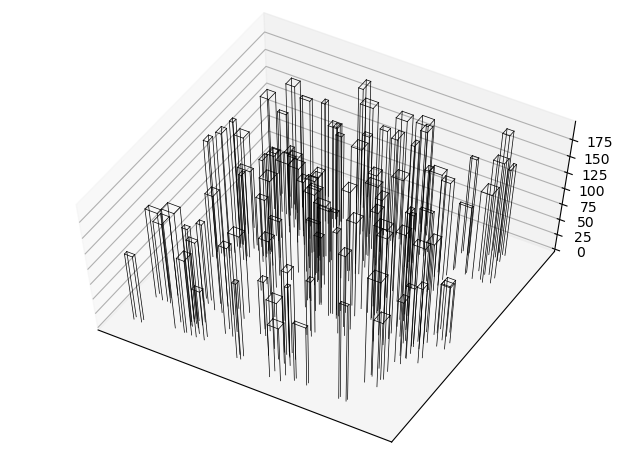

In [7]:
from mpl_toolkits import mplot3d 
import matplotlib.pyplot as plt 
import numpy as np
#interactive(True)

%matplotlib inline

fig = plt.figure(figsize=(8,6), dpi=100)
ax = plt.axes(projection='3d')

for building in obstacle.staticObsList:
    vertical1_x = [building.lon-building.length/2, building.lon-building.length/2]
    vertical1_y = [building.lat-building.width/2, building.lat-building.width/2]
    vertical1_z = [0, building.height]
    ax.plot3D(vertical1_x, vertical1_y, vertical1_z, c='black' , linewidth=0.5)

    vertical2_x = [building.lon-building.length/2, building.lon-building.length/2]
    vertical2_y = [building.lat+building.width/2, building.lat+building.width/2]
    vertical2_z = [0, building.height]
    ax.plot3D(vertical2_x, vertical2_y, vertical2_z, c='black' , linewidth=0.5)

    vertical3_x = [building.lon+building.length/2, building.lon+building.length/2]
    vertical3_y = [building.lat-building.width/2, building.lat-building.width/2]
    vertical3_z = [0, building.height]
    ax.plot3D(vertical3_x, vertical3_y, vertical3_z, c='black' , linewidth=0.5)

    vertical4_x = [building.lon+building.length/2, building.lon+building.length/2]
    vertical4_y = [building.lat+building.width/2, building.lat+building.width/2]
    vertical4_z = [0, building.height]
    ax.plot3D(vertical4_x, vertical4_y, vertical4_z, c='black' , linewidth=0.5)

    horizontal1_x = [building.lon-building.length/2, building.lon+building.length/2]
    horizontal1_y = [building.lat-building.width/2, building.lat-building.width/2]
    horizontal1_z = [building.height, building.height]
    ax.plot3D(horizontal1_x, horizontal1_y, horizontal1_z, c='black' , linewidth=0.5)

    horizontal2_x = [building.lon-building.length/2, building.lon+building.length/2]
    horizontal2_y = [building.lat+building.width/2, building.lat+building.width/2]
    horizontal2_z = [building.height, building.height]
    ax.plot3D(horizontal2_x, horizontal2_y, horizontal2_z, c='black' , linewidth=0.5)

    horizontal3_x = [building.lon-building.length/2, building.lon-building.length/2]
    horizontal3_y = [building.lat-building.width/2, building.lat+building.width/2]
    horizontal3_z = [building.height, building.height]
    ax.plot3D(horizontal3_x, horizontal3_y, horizontal3_z, c='black' , linewidth=0.5)

    horizontal4_x = [building.lon+building.length/2, building.lon+building.length/2]
    horizontal4_y = [building.lat-building.width/2, building.lat+building.width/2]
    horizontal4_z = [building.height, building.height]
    ax.plot3D(horizontal4_x, horizontal4_y, horizontal4_z, c='black' , linewidth=0.5)

ax.view_init(elev=60,azim=120)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
result = pd.DataFrame()
time_accu_d = 0
time_accu_a = 0
time_accu_4d = 0
delay_accu_4d = 0

result_d = []
result_a = []
result_4d = []
count=1
for flight in traffic.trafficPlan.scheduledFlights:
    time_start = time.time()
    finder_d = Dijkstra.Dij(airmatrix, flight.startPoint, flight.endPoint, flight.aircraft, traffic.odPairs)
    trajectory_d = AStar.Trajectory(airmatrix, finder_d.Search(), flight.aircraft, flight.departureTime)
    time_end = time.time()
    time_d = time_end-time_start
    time_accu_d += time_d
    result_d.append(trajectory_d)
    
    aobt_d = trajectory_d.trajectory[0][2]
    aibt_d = trajectory_d.trajectory[len(trajectory_d.trajectory)-1][2]
    cost_d = aibt_d-aobt_d
    print("d"+str(count))
    
    time_start = time.time()
    finder_a = AStar.AStarClassic(airmatrix, flight.startPoint, flight.endPoint, flight.aircraft, traffic.odPairs)
    trajectory_a = AStar.Trajectory(airmatrix, finder_a.Search(), flight.aircraft, flight.departureTime)
    time_end = time.time()
    time_a = time_end-time_start
    time_accu_a += time_a
    result_a.append(trajectory_a)
    astar_obstacles = AddDynamicObstacle(astar_obstacles, trajectory_a)
    astar_accum_conflicts = sum(sum(astar_obstacles.dynamicObsList>1))
    
    
    aobt_a = trajectory_a.trajectory[0][2]
    aibt_a = trajectory_a.trajectory[len(trajectory_a.trajectory)-1][2]
    cost_a = aibt_a-aobt_a
    print("a"+str(count))
    
    time_start = time.time()
    finder_4d = FourDimensionAStar.FourDimensionalAStar(airmatrix, flight.startPoint, flight.endPoint, flight.aircraft, 
                                                        flight.departureTime, dynamicObstacles, traffic.odPairs)
    trajectory_4d = finder_4d.Search()
    
    if(not trajectory_4d):
        break
    result_4d.append(trajectory_4d)
    
    time_end = time.time()
    time_4d = time_end-time_start
    time_accu_4d += time_4d
    dynamicObstacles = AddDynamicObstacle(dynamicObstacles, trajectory_4d)
    
    aobt_4d = trajectory_4d.trajectory[0][2]
    aibt_4d = trajectory_4d.trajectory[len(trajectory_4d.trajectory)-1][2]
    cost_4d = aibt_4d-aobt_4d
    delay_4d = cost_4d-cost_a
    delay_accu_4d += delay_4d
    print("4d"+str(count))
    count+=1
    new_data = {'Aircraft': flight.aircraft.name,'A-Star Cost':cost_a, 
                    'A-Star Computation Time':time_a,'A-Star Accumulated Computation Time':time_accu_a,
                    'CFA* Cost':cost_4d, 'CFA* Computation Time':time_4d, 'CFA* Accumulated Computation Time':time_accu_4d,
                    'CFA* Delay':delay_4d, 
                    'CFA* Accumulated Delay':delay_accu_4d, 'A-Star Accumulated Conflicts':astar_accum_conflicts}
        
    result = result.append(new_data, ignore_index=True)

d1
a1
4d1
d2
a2
4d2
d3
a3
4d3
d4
a4
4d4
d5
a5
4d5
d6
a6
4d6
d7
a7
4d7
d8
a8
4d8
d9
a9
4d9
d10
a10
4d10
d11
a11
4d11
d12
a12
4d12
d13
a13
4d13
d14
a14
4d14
d15
a15
4d15
d16
a16
4d16
d17
a17
4d17
d18
a18
4d18
d19
a19
4d19
d20
a20
4d20
d21
a21
4d21
d22
a22
4d22
d23
a23
4d23
d24
a24
4d24
d25
a25
4d25
d26
a26
4d26
d27
a27
4d27
d28
a28
4d28
d29
a29
4d29
d30
a30
4d30
d31
a31
4d31
d32
a32
4d32
d33
a33
4d33
d34
a34
4d34
d35
a35
4d35
d36
a36
4d36
d37
a37
4d37
d38
a38
4d38
d39
a39
4d39
d40
a40
4d40
d41
a41
4d41
d42
a42
4d42
d43
a43
4d43
d44
a44
4d44
d45
a45
4d45
d46
a46
4d46
d47
a47
4d47
d48
a48
4d48
d49
a49
4d49
d50
a50
4d50
d51
a51
4d51
d52
a52
4d52
d53
a53
4d53
d54
a54
4d54
d55
a55
4d55
d56
a56
4d56
d57
a57
4d57


In [ ]:
result

In [ ]:
# building plotting
from mpl_toolkits import mplot3d 
import matplotlib.pyplot as plt 
import numpy as np
#interactive(True)

%matplotlib inline

fig = plt.figure(figsize=(8,6), dpi=100)
ax = plt.axes(projection='3d')

for building in obstacle.staticObsList:
    vertical1_x = [building.lon-building.length/2, building.lon-building.length/2]
    vertical1_y = [building.lat-building.width/2, building.lat-building.width/2]
    vertical1_z = [0, building.height]
    ax.plot3D(vertical1_x, vertical1_y, vertical1_z, c='black', linewidth=0.5)

    vertical2_x = [building.lon-building.length/2, building.lon-building.length/2]
    vertical2_y = [building.lat+building.width/2, building.lat+building.width/2]
    vertical2_z = [0, building.height]
    ax.plot3D(vertical2_x, vertical2_y, vertical2_z, c='black', linewidth=0.5)

    vertical3_x = [building.lon+building.length/2, building.lon+building.length/2]
    vertical3_y = [building.lat-building.width/2, building.lat-building.width/2]
    vertical3_z = [0, building.height]
    ax.plot3D(vertical3_x, vertical3_y, vertical3_z, c='black', linewidth=0.5)

    vertical4_x = [building.lon+building.length/2, building.lon+building.length/2]
    vertical4_y = [building.lat+building.width/2, building.lat+building.width/2]
    vertical4_z = [0, building.height]
    ax.plot3D(vertical4_x, vertical4_y, vertical4_z, c='black', linewidth=0.5)

    horizontal1_x = [building.lon-building.length/2, building.lon+building.length/2]
    horizontal1_y = [building.lat-building.width/2, building.lat-building.width/2]
    horizontal1_z = [building.height, building.height]
    ax.plot3D(horizontal1_x, horizontal1_y, horizontal1_z, c='black', linewidth=0.5)

    horizontal2_x = [building.lon-building.length/2, building.lon+building.length/2]
    horizontal2_y = [building.lat+building.width/2, building.lat+building.width/2]
    horizontal2_z = [building.height, building.height]
    ax.plot3D(horizontal2_x, horizontal2_y, horizontal2_z, c='black', linewidth=0.5)

    horizontal3_x = [building.lon-building.length/2, building.lon-building.length/2]
    horizontal3_y = [building.lat-building.width/2, building.lat+building.width/2]
    horizontal3_z = [building.height, building.height]
    ax.plot3D(horizontal3_x, horizontal3_y, horizontal3_z, c='black' ,linewidth=0.5)

    horizontal4_x = [building.lon+building.length/2, building.lon+building.length/2]
    horizontal4_y = [building.lat-building.width/2, building.lat+building.width/2]
    horizontal4_z = [building.height, building.height]
    ax.plot3D(horizontal4_x, horizontal4_y, horizontal4_z, c='black', linewidth=0.5)

    
k =6


# Dijkstra
# trajectory = result_a[k]

# x = [(trajectory.trajectory[0][0].point.x+0.5)*airmatrix.cellLength, (trajectory.trajectory[0][0].point.x+0.5)*airmatrix.cellLength]
# y = [(trajectory.trajectory[0][0].point.y+0.5)*airmatrix.cellWidth, (trajectory.trajectory[0][0].point.y+0.5)*airmatrix.cellWidth]
# z = [0, airmatrix.cellHeight/2]
# ax.plot3D(x,y,z,c='blue',linewidth=2)

# x = [(trajectory.trajectory[len(trajectory.trajectory)-1][0].point.x+0.5)*airmatrix.cellLength, (trajectory.trajectory[len(trajectory.trajectory)-1][0].point.x+0.5)*airmatrix.cellLength]
# y = [(trajectory.trajectory[len(trajectory.trajectory)-1][0].point.y+0.5)*airmatrix.cellWidth, (trajectory.trajectory[len(trajectory.trajectory)-1][0].point.y+0.5)*airmatrix.cellWidth]
# z = [0, airmatrix.cellHeight/2]
# ax.plot3D(x,y,z,c='blue',linewidth=2)

# for i in range(len(trajectory.trajectory)-1):
#     point_1 = trajectory.trajectory[i][0].point
#     point_2 = trajectory.trajectory[i+1][0].point
#     x = [(point_1.x+0.5)*airmatrix.cellLength, (point_2.x+0.5)*airmatrix.cellLength]
#     y = [(point_1.y+0.5)*airmatrix.cellWidth, (point_2.y+0.5)*airmatrix.cellWidth]
#     z = [(point_1.z+0.5)*airmatrix.cellHeight, (point_2.z+0.5)*airmatrix.cellHeight]
#     ax.plot3D(x,y,z,c='blue',linewidth=2)

# CFA*
trajectory = result_4d[k]

x = [(trajectory.trajectory[0][0].point.x+0.5)*airmatrix.cellLength, (trajectory.trajectory[0][0].point.x+0.5)*airmatrix.cellLength]
y = [(trajectory.trajectory[0][0].point.y+0.5)*airmatrix.cellWidth, (trajectory.trajectory[0][0].point.y+0.5)*airmatrix.cellWidth]
z = [0, airmatrix.cellHeight/2]
ax.plot3D(x,y,z,c='blue',linewidth=3)

x = [(trajectory.trajectory[len(trajectory.trajectory)-1][0].point.x+0.5)*airmatrix.cellLength, (trajectory.trajectory[len(trajectory.trajectory)-1][0].point.x+0.5)*airmatrix.cellLength]
y = [(trajectory.trajectory[len(trajectory.trajectory)-1][0].point.y+0.5)*airmatrix.cellWidth, (trajectory.trajectory[len(trajectory.trajectory)-1][0].point.y+0.5)*airmatrix.cellWidth]
z = [0, airmatrix.cellHeight/2]
ax.plot3D(x,y,z,c='blue',linewidth=3)

for i in range(len(trajectory.trajectory)-1):
    point_1 = trajectory.trajectory[i][0].point
    point_2 = trajectory.trajectory[i+1][0].point
    x = [(point_1.x+0.5)*airmatrix.cellLength, (point_2.x+0.5)*airmatrix.cellLength]
    y = [(point_1.y+0.5)*airmatrix.cellWidth, (point_2.y+0.5)*airmatrix.cellWidth]
    z = [(point_1.z+0.5)*airmatrix.cellHeight, (point_2.z+0.5)*airmatrix.cellHeight]
    ax.plot3D(x,y,z,c='blue',linewidth=3)


# a-star
trajectory = result_a[k]

x = [(trajectory.trajectory[0][0].point.x+0.5)*airmatrix.cellLength, (trajectory.trajectory[0][0].point.x+0.5)*airmatrix.cellLength]
y = [(trajectory.trajectory[0][0].point.y+0.5)*airmatrix.cellWidth, (trajectory.trajectory[0][0].point.y+0.5)*airmatrix.cellWidth]
z = [0, airmatrix.cellHeight/2]
ax.plot3D(x,y,z,c='red',linewidth=3, alpha=0.5)

x = [(trajectory.trajectory[len(trajectory.trajectory)-1][0].point.x+0.5)*airmatrix.cellLength, (trajectory.trajectory[len(trajectory.trajectory)-1][0].point.x+0.5)*airmatrix.cellLength]
y = [(trajectory.trajectory[len(trajectory.trajectory)-1][0].point.y+0.5)*airmatrix.cellWidth, (trajectory.trajectory[len(trajectory.trajectory)-1][0].point.y+0.5)*airmatrix.cellWidth]
z = [0, airmatrix.cellHeight/2]
ax.plot3D(x,y,z,c='red',linewidth=3, alpha=0.5)

for i in range(len(trajectory.trajectory)-1):
    point_1 = trajectory.trajectory[i][0].point
    point_2 = trajectory.trajectory[i+1][0].point
    x = [(point_1.x+0.5)*airmatrix.cellLength, (point_2.x+0.5)*airmatrix.cellLength]
    y = [(point_1.y+0.5)*airmatrix.cellWidth, (point_2.y+0.5)*airmatrix.cellWidth]
    z = [(point_1.z+0.5)*airmatrix.cellHeight, (point_2.z+0.5)*airmatrix.cellHeight]
    ax.plot3D(x,y,z,c='red',linewidth=3, alpha=0.5)

ax.view_init(elev=60,azim=120)
plt.xticks([])
plt.yticks([])
plt.legend(labels=['A-Star', 'CFA*'],loc='best')
plt.show()


In [ ]:
k = 122
print(result_d[k].trajectory[len(result_d[k].trajectory)-1][0].point)
print(result_a[k].trajectory[len(result_a[k].trajectory)-1][0].point)
#print(result_4d[k].trajectory[len(result_4d[k].trajectory)-1][0].point)
print(traffic.trafficPlan.scheduledFlights[k])

In [ ]:
print(traffic.trafficPlan.scheduledFlights[122].endPoint)

In [ ]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
result.head(250)

In [ ]:
result.to_csv("D:/Dropbox/TRC_SI/revised.csv")

In [ ]:
astar_obstacles = DynamicObstacle.DynamicObstacles(airmatrix.indexRange[0]*airmatrix.indexRange[1]*airmatrix.indexRange[2], 3600)
astar_accu_conflict = []
for flight in result_a:
    astar_obstacles = AddDynamicObstacle(astar_obstacles, flight)
    astar_accu_conflict.append(sum(sum(astar_obstacles.dynamicObsList>1)))


In [ ]:
import pickle

In [ ]:
with open('D:/Dropbox/TRC_SI/data/obstacle.pickle', 'wb') as f:
    pickle.dump(obstacle, f)

with open('D:/Dropbox/TRC_SI/data/result_a.pickle', 'wb') as f:
    pickle.dump(result_a, f)
    
with open('D:/Dropbox/TRC_SI/data/result_4d.pickle', 'wb') as f:
    pickle.dump(result_4d, f)

with open('D:/Dropbox/TRC_SI/data/airmatrix.pickle', 'wb') as f:
    pickle.dump(airmatrix, f)

with open('D:/Dropbox/TRC_SI/data/traffic.pickle', 'wb') as f:
    pickle.dump(traffic, f)

In [ ]:
altitude_utilization = []
for z in range(5):
    heat_distribution = np.zeros((80,80))
    altitude_utilization.append(heat_distribution)

for trajectory in result_4d:
    startT = trajectory.trajectory[0][2]
    atT = trajectory.trajectory[0][2]
    for i in range(len(trajectory.trajectory)-1):
        
        x = trajectory.trajectory[i][0].point.x
        y = trajectory.trajectory[i][0].point.y
        z = trajectory.trajectory[i][0].point.z
        altitude_utilization[z][x,y] += (np.ceil((trajectory.trajectory[i+1][2] + atT) / 2) - startT)
        startT = int((trajectory.trajectory[i+1][2] + atT) / 2)
        atT = trajectory.trajectory[i + 1][2]
    x = trajectory.trajectory[len(trajectory.trajectory)-1][0].point.x
    y = trajectory.trajectory[len(trajectory.trajectory)-1][0].point.y
    z = trajectory.trajectory[len(trajectory.trajectory)-1][0].point.z
    altitude_utilization[z][x,y] += (trajectory.trajectory[len(trajectory.trajectory)-1][2] - startT)

In [ ]:
import seaborn as sns

In [ ]:
fig = plt.figure(figsize=(20,6), dpi=300)
sns.set()
heatmap_1 = fig.add_subplot(131)
heatmap_1 = sns.heatmap(altitude_utilization[0],vmin=0, vmax=65, cbar=False).invert_yaxis()
plt.xticks([])
plt.yticks([])
heatmap_2 = fig.add_subplot(132)
heatmap_2 = sns.heatmap(altitude_utilization[1],vmin=0, vmax=65, cbar=False).invert_yaxis()
plt.xticks([])
plt.yticks([])
heatmap_3 = fig.add_subplot(133)
heatmap_3 = sns.heatmap(altitude_utilization[2],vmin=0, vmax=65, cbar=False).invert_yaxis()
plt.xticks([])
plt.yticks([])

In [ ]:
np.max(altitude_utilization[0])

In [ ]:
fig = plt.figure(figsize=(6,6), dpi=300)
sns.set()
heatmap_1 = sns.heatmap(altitude_utilization[0],vmin=0, vmax=65, cbar=False).invert_yaxis()
plt.xticks([])
plt.yticks([])